## Part 2: Spam Classification using Recurrent Neural Networks

###### Curated By - Paritosh Sinha

#### Importing the necessary library

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Bidirectional, Dense, Flatten
from tensorflow.keras.preprocessing import sequence
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import Activation
# Set seed for reproducibility
SEED = 1234
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# Constants
max_features = 10000
maxlen = 500
batch_size = 32
embedding_dim = 100  # Adjust based on your GloVe file.

'''glove.6B.50d.txt - 6 Billion token and 50 Features
glove.6B.100d.txt - 6 Billion token and 100 Features
glove.6B.200d.txt - 6 Billion token and 200 Features
glove.6B.300d.txt - 6 Billion token and 300 Features'''

'glove.6B.50d.txt - 6 Billion token and 50 Features\nglove.6B.100d.txt - 6 Billion token and 100 Features\nglove.6B.200d.txt - 6 Billion token and 200 Features\nglove.6B.300d.txt - 6 Billion token and 300 Features'

#### Importing the Dataset

In [3]:
#Load the dataset
df_spam = pd.read_csv('./SPAM_text_message.csv', header=0) # load
df_spam = df_spam.sample(frac=1).reset_index(drop=True) # shuffle
df_spam.head()

,Category,Message
0,ham,How's it feel? Mr. Your not my real Valentine ...
1,ham,"Watching cartoon, listening music &amp; at eve..."
2,ham,Ok i msg u b4 i leave my house.
3,ham,Didn't you get hep b immunisation in nigeria.
4,ham,Huh so early.. Then ü having dinner outside iz...


In [4]:
print(Tokenizer(df_spam))

### 1. Data pre-processing

### Tokenization of Sequence

In [5]:

# Assuming df_spam is your DataFrame with 'Category' and 'Message' columns

# Preprocessing
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_spam['Message'])
sequences = tokenizer.texts_to_sequences(df_spam['Message'])
X_train = pad_sequences(sequences)
print(X_train)

# Convert 'Category' to binary labels (0 for 'ham' and 1 for 'spam')
df_spam['Category'] = df_spam['Category'].apply(lambda x: 1 if x == 'spam' else 0)
y_train = df_spam['Category'].values
print(y_train)



[[   0    0    0 ...    6 2993  325]
 [   0    0    0 ...   53   81    6]
 [   0    0    0 ...  242   11  301]
 ...
 [   0    0    0 ...  209 2376 3561]
 [   0    0    0 ... 9003  599 9004]
 [   0    0    0 ...   36    3 2316]]
[0 0 0 ... 1 0 1]


In [6]:
#Shuffle the data and Splitting it into Train and test with y labels

training_samples = int(len(df_spam['Category']) * .8)
validation_samples = int(len(df_spam['Category']) - training_samples)

np.random.seed(42)

indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)
data = X_train[indices]
labels = y_train[indices]


texts_train = X_train[:training_samples]
y_train_1 = labels[:training_samples]
X_test = data[training_samples:]
y_test = labels[training_samples:]

#### Importing the embeddings

In [7]:
#Path to the pre trained word embedding file
path_to_glove_file = "C:/Users/Deepti Gupta/Python_Code/Term 4/AMPBA_DeepLearning_Code/Day4_RNN/data/glove.twitter.27B.100d/glove.twitter.27B.100d.txt"

#Initialise dictionary where we will store the word embeddings
embeddings_index = {}

#Reading the glove file, reads each line of the file 
with open(path_to_glove_file, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) #Splits each word and its corresponding embedding vector (coefs)
        coefs = np.fromstring(coefs, "f", sep=" ") #Convert the embedding vector into an array
        embeddings_index[word] = coefs #associates each word with its embedding vector in the embeddings_index dictionary.

print(f"Found {len(embeddings_index)} word vectors.")

Found 1193514 word vectors.


In [8]:
# Plot training history
def plot_training_history(history, title):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure()
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(title + ' - Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(title + ' - Training and validation loss')
    plt.legend()
    plt.show()


In [9]:
def evaluate_accuracy(model, X_test, y_test):
    # Evaluate the model
    test_pred = model.predict(X_test)

    # Convert predictions to labels
    test_pred_labels = (test_pred > 0.5).astype(int)

    # Convert y_test to numpy array
    y_test_numpy = y_test.flatten()

    # Calculate accuracy
    accuracy = accuracy_score(y_test_numpy, test_pred_labels)

    # Print statistical metrics
    print("Accuracy of simple_rnn_model:", accuracy)


#### Converting words into numeric vectors of embeddings

In [10]:
#Initialise the word embedding matrix
word_index = {}
#Filling the initailsed matrix with all zeros. This matrix will store the embedding vectors for each word.
embedding_matrix = np.zeros((max_features, embedding_dim))

# Iterate over the DataFrame to create word_index and embedding_matrix
for index, row in df_spam.iterrows():
    message = row['Message']
    words = message.split()  # Split the message into words
    
    for word in words:
        # Create a unique index for each word
        if word not in word_index:
            word_index[word] = len(word_index) + 1  # Index 0 is reserved for padding
    
    # Assign the embedding vector to the corresponding row in the embedding matrix
    for word in words:
        i = word_index[word]
        if i < max_features:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector


##### Experiment 1 : SimpleRNN with GloVe embeddings

In [11]:
# SimpleRNN with GloVe embeddings
simple_rnn_model = tf.keras.Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), # Constant initializer is to load the pretrained embeddings in an Embedding layer. So as not to disrupt the pretrained representations during training, we freeze the layer via trainable=False:
              trainable=False),
    SimpleRNN(32),
    Dense(1, activation='sigmoid')
])

simple_rnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [12]:
simple_rnn_history = simple_rnn_model.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
35/35 [==============================] - 2s 37ms/step - loss: 0.4264 - acc: 0.8382 - val_loss: 0.3821 - val_acc: 0.8574
Epoch 2/5
35/35 [==============================] - 1s 36ms/step - loss: 0.3035 - acc: 0.8860 - val_loss: 0.2699 - val_acc: 0.8960
Epoch 3/5
35/35 [==============================] - 1s 38ms/step - loss: 0.2117 - acc: 0.9226 - val_loss: 0.2341 - val_acc: 0.9157
Epoch 4/5
35/35 [==============================] - 2s 44ms/step - loss: 0.1811 - acc: 0.9363 - val_loss: 0.2023 - val_acc: 0.9327
Epoch 5/5
35/35 [==============================] - 1s 36ms/step - loss: 0.1618 - acc: 0.9441 - val_loss: 0.1933 - val_acc: 0.9318


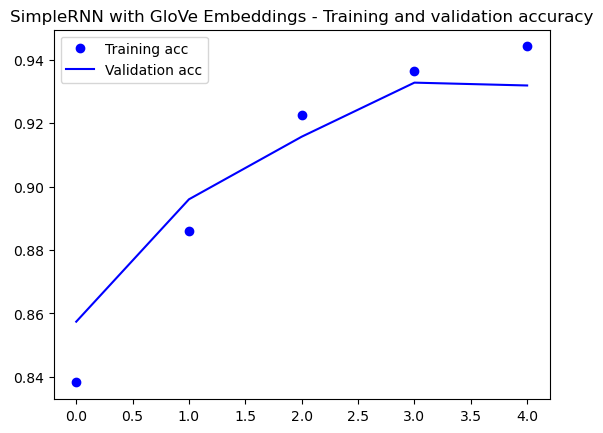

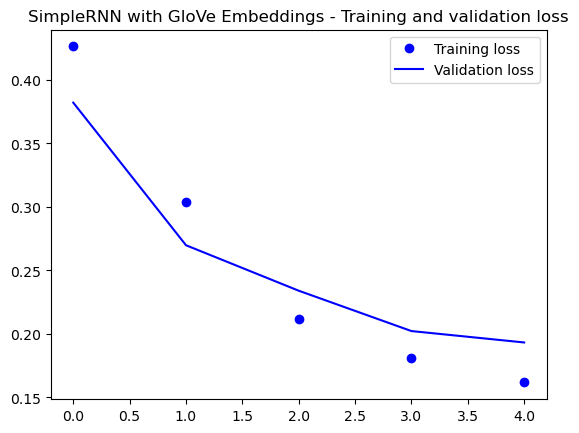

In [13]:
plot_training_history(simple_rnn_history, 'SimpleRNN with GloVe Embeddings')

In [14]:

# simple_rnn_model and X_test, y_test are your test set and labels
evaluate_accuracy(simple_rnn_model, X_test, y_test)


35/35 [==============================] - 0s 6ms/step
Accuracy of simple_rnn_model: 0.9542600896860987


##### Experiment 2 : Bidirectional SimpleRNN with GloVe embeddings

In [15]:

# Bidirectional SimpleRNN with GloVe embeddings
bidirectional_rnn_model = tf.keras.Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              trainable=False),
    Bidirectional(SimpleRNN(32)),
    Dense(1, activation='sigmoid')
])

bidirectional_rnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


In [16]:
bidirectional_rnn_history = bidirectional_rnn_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
35/35 [==============================] - 2s 40ms/step - loss: 0.3959 - acc: 0.8618 - val_loss: 0.3961 - val_acc: 0.8511
Epoch 2/10
35/35 [==============================] - 1s 36ms/step - loss: 0.3441 - acc: 0.8667 - val_loss: 0.3206 - val_acc: 0.8619
Epoch 3/10
35/35 [==============================] - 1s 35ms/step - loss: 0.2700 - acc: 0.8858 - val_loss: 0.2551 - val_acc: 0.8969
Epoch 4/10
35/35 [==============================] - 1s 37ms/step - loss: 0.2169 - acc: 0.9123 - val_loss: 0.2398 - val_acc: 0.9094
Epoch 5/10
35/35 [==============================] - 1s 37ms/step - loss: 0.1894 - acc: 0.9260 - val_loss: 0.2096 - val_acc: 0.9238
Epoch 6/10
35/35 [==============================] - 1s 36ms/step - loss: 0.1720 - acc: 0.9343 - val_loss: 0.2107 - val_acc: 0.9265
Epoch 7/10
35/35 [==============================] - 1s 34ms/step - loss: 0.1581 - acc: 0.9417 - val_loss: 0.2095 - val_acc: 0.9309
Epoch 8/10
35/35 [==============================] - 1s 36ms/step - loss: 0.1364 - a

In [17]:
#X_test and y_test are your test set and labels

# bidirectional_rnn_model and X_test, y_test are your test set and labels
evaluate_accuracy(bidirectional_rnn_model, X_test, y_test)


35/35 [==============================] - 1s 14ms/step
Accuracy of simple_rnn_model: 0.9713004484304932


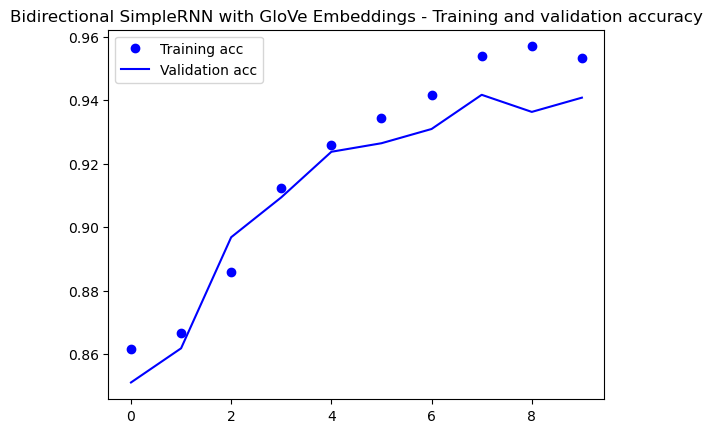

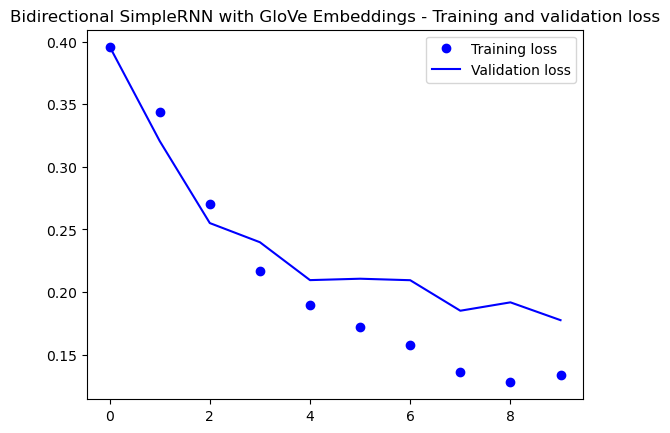

In [18]:
plot_training_history(bidirectional_rnn_history, 'Bidirectional SimpleRNN with GloVe Embeddings')

##### Experiment 3 :  Deep Bidirectional SimpleRNN with GloVe embeddings

In [19]:
# Deep Bidirectional SimpleRNN with GloVe embeddings
deep_bidirectional_rnn_model = tf.keras.Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              trainable=False),
    Bidirectional(SimpleRNN(32, return_sequences=True)),
    Bidirectional(SimpleRNN(32)),
    Dense(1, activation='sigmoid')
])

deep_bidirectional_rnn_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [20]:
deep_bidirectional_rnn_history = deep_bidirectional_rnn_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
35/35 [==============================] - 5s 98ms/step - loss: 0.3678 - acc: 0.8663 - val_loss: 0.2793 - val_acc: 0.8825
Epoch 2/10
35/35 [==============================] - 4s 107ms/step - loss: 0.2207 - acc: 0.9143 - val_loss: 0.2118 - val_acc: 0.9274
Epoch 3/10
35/35 [==============================] - 4s 106ms/step - loss: 0.1744 - acc: 0.9358 - val_loss: 0.2168 - val_acc: 0.9148
Epoch 4/10
35/35 [==============================] - 4s 112ms/step - loss: 0.1540 - acc: 0.9462 - val_loss: 0.2043 - val_acc: 0.9300
Epoch 5/10
35/35 [==============================] - 4s 106ms/step - loss: 0.1345 - acc: 0.9578 - val_loss: 0.1842 - val_acc: 0.9300
Epoch 6/10
35/35 [==============================] - 4s 103ms/step - loss: 0.1215 - acc: 0.9610 - val_loss: 0.1675 - val_acc: 0.9372
Epoch 7/10
35/35 [==============================] - 4s 106ms/step - loss: 0.1099 - acc: 0.9663 - val_loss: 0.1894 - val_acc: 0.9408
Epoch 8/10
35/35 [==============================] - 4s 108ms/step - loss: 0.1

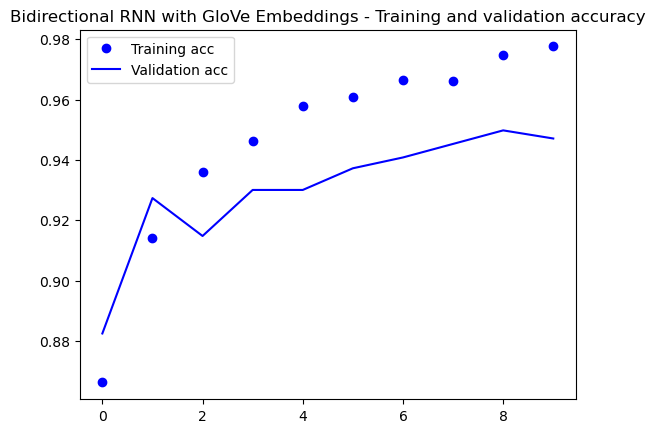

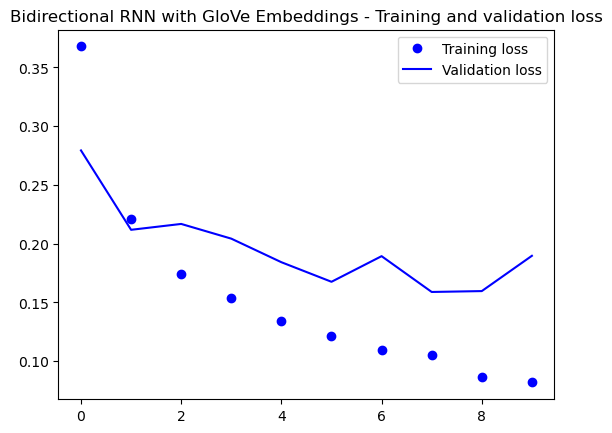

In [21]:
plot_training_history(deep_bidirectional_rnn_history, 'Bidirectional RNN with GloVe Embeddings')

In [22]:
# Evaluate the model
# deep_bidirectional_rnn_model and X_test, y_test are your test set and labels
evaluate_accuracy(deep_bidirectional_rnn_model, X_test, y_test)


35/35 [==============================] - 1s 21ms/step
Accuracy of simple_rnn_model: 0.9748878923766816


###### Experiment 4 : SimpleRNN with other Activation Function

In [23]:
# SimpleRNN with GloVe embeddings
simple_rnn_model_adam = tf.keras.Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), # Constant initializer is to load the pretrained embeddings in an Embedding layer. So as not to disrupt the pretrained representations during training, we freeze the layer via trainable=False:
              trainable=False),
    SimpleRNN(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

simple_rnn_model_adam.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['acc'])

In [24]:
simple_rnn_history_adam = simple_rnn_model_adam.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2,)

Epoch 1/5
35/35 [==============================] - 2s 37ms/step - loss: 0.4174 - acc: 0.8591 - val_loss: 0.4116 - val_acc: 0.8538
Epoch 2/5
35/35 [==============================] - 1s 36ms/step - loss: 0.3890 - acc: 0.8548 - val_loss: 0.4008 - val_acc: 0.8574
Epoch 3/5
35/35 [==============================] - 1s 35ms/step - loss: 0.3902 - acc: 0.8759 - val_loss: 0.4488 - val_acc: 0.8565
Epoch 4/5
35/35 [==============================] - 1s 35ms/step - loss: 0.3480 - acc: 0.8820 - val_loss: 0.4336 - val_acc: 0.8574
Epoch 5/5
35/35 [==============================] - 2s 44ms/step - loss: 0.3361 - acc: 0.8869 - val_loss: 0.4403 - val_acc: 0.8673


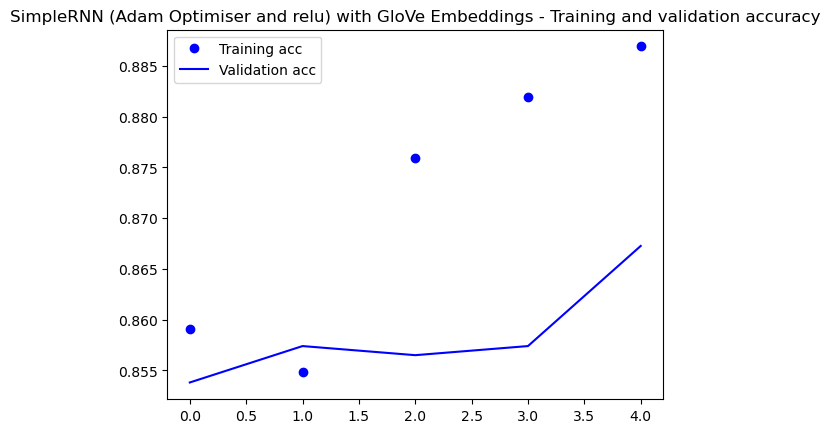

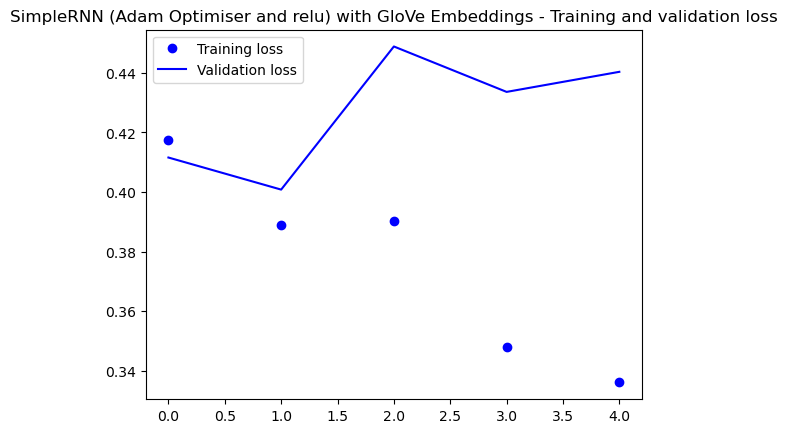

In [25]:

plot_training_history(simple_rnn_history_adam, 'SimpleRNN (Adam Optimiser and relu) with GloVe Embeddings')

In [26]:
# Evaluate the model
# simple_rnn_model and X_test, y_test are your test set and labels
evaluate_accuracy(simple_rnn_model_adam, X_test, y_test)

35/35 [==============================] - 1s 12ms/step
Accuracy of simple_rnn_model: 0.8959641255605382


##### Experiment 5 : Bidirectional RNN with other Activation Function

In [27]:
#SGD(learning_rate=0.01)

# Deep Bidirectional SimpleRNN SGD with GloVe embeddings
deep_bidirectional_rnn_model_sgd = tf.keras.Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              trainable=False),
    Bidirectional(SimpleRNN(32, return_sequences=True)),
    Bidirectional(SimpleRNN(32)),
    Dense(1, activation='sigmoid')
])

deep_bidirectional_rnn_model_sgd.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['acc'])

In [28]:
deep_bidirectional_rnn_model_sgd = deep_bidirectional_rnn_model_sgd.fit(X_train, y_train, epochs=5, batch_size=128, validation_split=0.2)

Epoch 1/5
35/35 [==============================] - 5s 110ms/step - loss: 0.4092 - acc: 0.8589 - val_loss: 0.4067 - val_acc: 0.8520
Epoch 2/5
35/35 [==============================] - 4s 111ms/step - loss: 0.3785 - acc: 0.8692 - val_loss: 0.4022 - val_acc: 0.8520
Epoch 3/5
35/35 [==============================] - 4s 108ms/step - loss: 0.3730 - acc: 0.8694 - val_loss: 0.3972 - val_acc: 0.8520
Epoch 4/5
35/35 [==============================] - 4s 122ms/step - loss: 0.3676 - acc: 0.8694 - val_loss: 0.3914 - val_acc: 0.8520
Epoch 5/5
35/35 [==============================] - 4s 105ms/step - loss: 0.3616 - acc: 0.8694 - val_loss: 0.3847 - val_acc: 0.8520


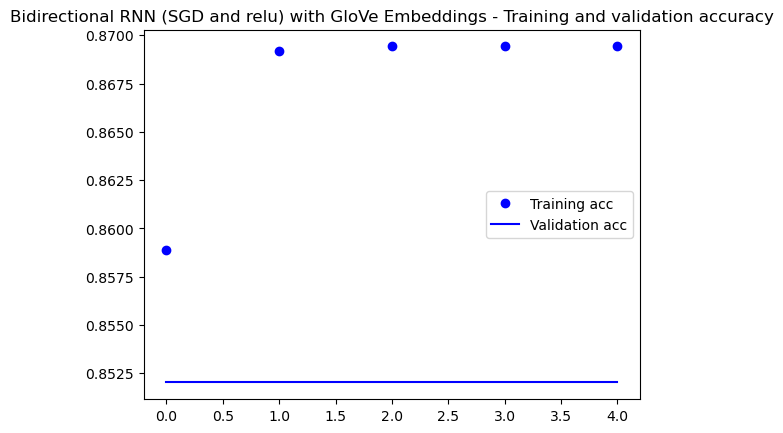

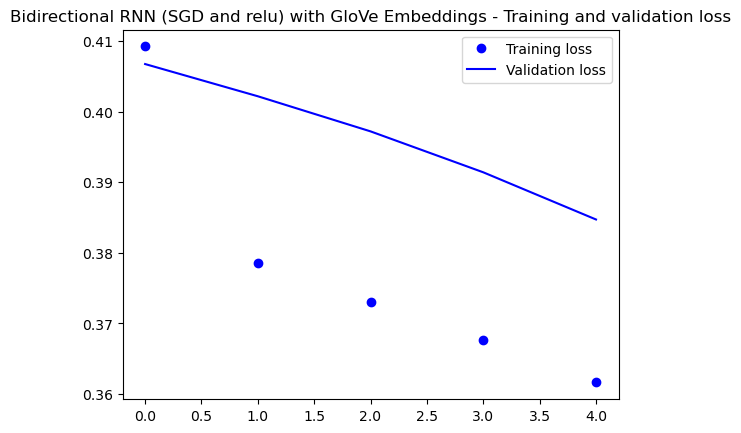

In [29]:
plot_training_history(deep_bidirectional_rnn_model_sgd, 'Bidirectional RNN (SGD and relu) with GloVe Embeddings')

## LSTM with GloVe embeddings

In [30]:
# LSTM with GloVe embeddings
lstm_model = tf.keras.Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              trainable=False),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


In [31]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.2)


Epoch 1/50
35/35 [==============================] - 5s 113ms/step - loss: 0.4421 - acc: 0.8535 - val_loss: 0.3955 - val_acc: 0.8520
Epoch 2/50
35/35 [==============================] - 4s 117ms/step - loss: 0.2770 - acc: 0.8874 - val_loss: 0.2323 - val_acc: 0.9220
Epoch 3/50
35/35 [==============================] - 4s 118ms/step - loss: 0.1855 - acc: 0.9358 - val_loss: 0.1986 - val_acc: 0.9274
Epoch 4/50
35/35 [==============================] - 4s 117ms/step - loss: 0.1551 - acc: 0.9504 - val_loss: 0.1806 - val_acc: 0.9381
Epoch 5/50
35/35 [==============================] - 4s 117ms/step - loss: 0.1367 - acc: 0.9542 - val_loss: 0.1539 - val_acc: 0.9489
Epoch 6/50
35/35 [==============================] - 4s 110ms/step - loss: 0.1292 - acc: 0.9621 - val_loss: 0.1564 - val_acc: 0.9489
Epoch 7/50
35/35 [==============================] - 4s 115ms/step - loss: 0.1198 - acc: 0.9623 - val_loss: 0.1409 - val_acc: 0.9543
Epoch 8/50
35/35 [==============================] - 4s 115ms/step - loss: 0.

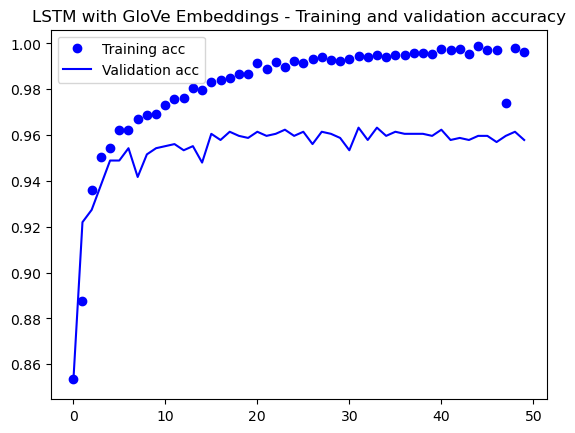

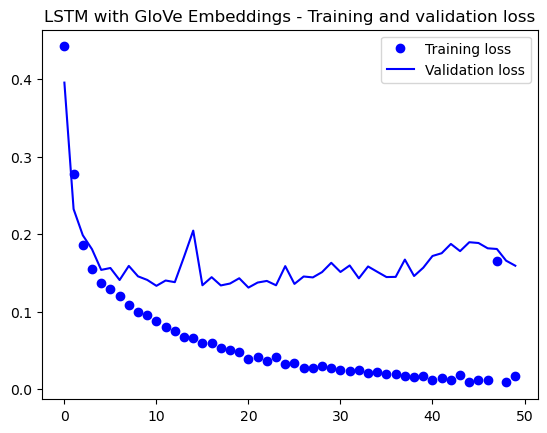

In [32]:

plot_training_history(lstm_history, 'LSTM with GloVe Embeddings')


In [33]:
# Evaluate the model
# lstm_model and X_test, y_test are your test set and labels
evaluate_accuracy(lstm_model, X_test, y_test)

35/35 [==============================] - 1s 13ms/step
Accuracy of simple_rnn_model: 0.9946188340807175


##### Bidirectional LSTM with GloVe embeddings

In [34]:

# Bidirectional LSTM with GloVe embeddings
bidirectional_lstm_model = tf.keras.Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              trainable=False),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

bidirectional_lstm_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


In [35]:
bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
35/35 [==============================] - 9s 205ms/step - loss: 0.4490 - acc: 0.8447 - val_loss: 0.4086 - val_acc: 0.8520
Epoch 2/10
35/35 [==============================] - 7s 196ms/step - loss: 0.3446 - acc: 0.8694 - val_loss: 0.2944 - val_acc: 0.8529
Epoch 3/10
35/35 [==============================] - 7s 194ms/step - loss: 0.2282 - acc: 0.9024 - val_loss: 0.2228 - val_acc: 0.9175
Epoch 4/10
35/35 [==============================] - 7s 201ms/step - loss: 0.1837 - acc: 0.9363 - val_loss: 0.1865 - val_acc: 0.9345
Epoch 5/10
35/35 [==============================] - 7s 212ms/step - loss: 0.1548 - acc: 0.9506 - val_loss: 0.1711 - val_acc: 0.9444
Epoch 6/10
35/35 [==============================] - 7s 215ms/step - loss: 0.1353 - acc: 0.9565 - val_loss: 0.1492 - val_acc: 0.9534
Epoch 7/10
35/35 [==============================] - 7s 197ms/step - loss: 0.1221 - acc: 0.9648 - val_loss: 0.1735 - val_acc: 0.9327
Epoch 8/10
35/35 [==============================] - 7s 205ms/step - loss: 0.

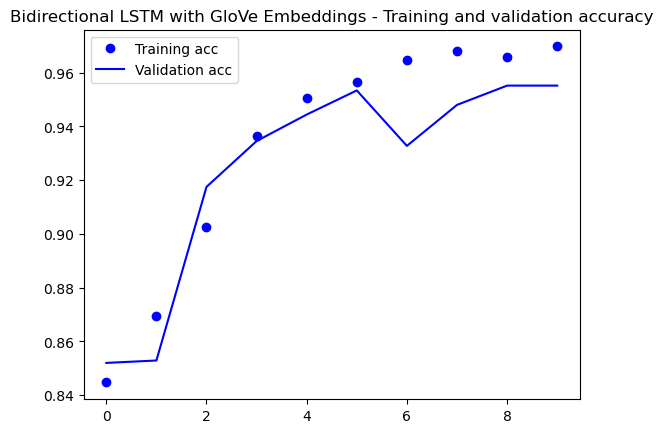

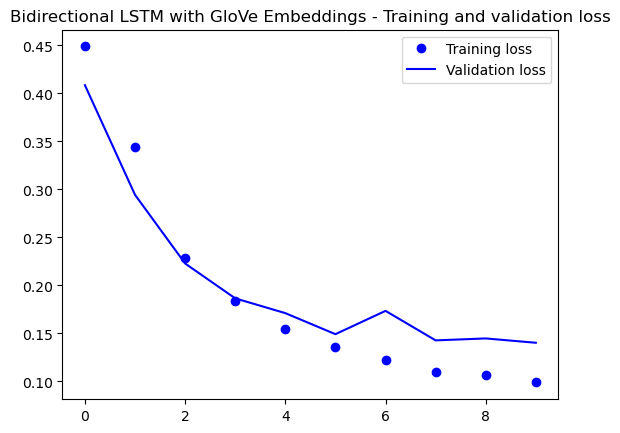

In [36]:
plot_training_history(bidirectional_lstm_history, 'Bidirectional LSTM with GloVe Embeddings')

In [37]:

# Evaluate the model
# bidirectional_lstm_model and X_test, y_test are your test set and labels
evaluate_accuracy(bidirectional_lstm_model, X_test, y_test)


35/35 [==============================] - 2s 32ms/step
Accuracy of simple_rnn_model: 0.9757847533632287


##### Deep Bidirectional LSTM with GloVe embeddings

In [38]:
# Deep Bidirectional LSTM with GloVe embeddings
deep_bidirectional_lstm_model = tf.keras.Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              trainable=False),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(1, activation='sigmoid')
])

deep_bidirectional_lstm_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [39]:
deep_bidirectional_lstm_history = deep_bidirectional_lstm_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
35/35 [==============================] - 21s 512ms/step - loss: 0.4156 - acc: 0.8483 - val_loss: 0.3287 - val_acc: 0.8520
Epoch 2/10
35/35 [==============================] - 20s 563ms/step - loss: 0.2381 - acc: 0.9067 - val_loss: 0.2059 - val_acc: 0.9184
Epoch 3/10
35/35 [==============================] - 21s 596ms/step - loss: 0.1772 - acc: 0.9408 - val_loss: 0.1749 - val_acc: 0.9417
Epoch 4/10
35/35 [==============================] - 20s 580ms/step - loss: 0.1484 - acc: 0.9484 - val_loss: 0.1935 - val_acc: 0.9354
Epoch 5/10
35/35 [==============================] - 20s 566ms/step - loss: 0.1278 - acc: 0.9594 - val_loss: 0.1533 - val_acc: 0.9516
Epoch 6/10
35/35 [==============================] - 19s 557ms/step - loss: 0.1162 - acc: 0.9637 - val_loss: 0.1809 - val_acc: 0.9408
Epoch 7/10
35/35 [==============================] - 21s 589ms/step - loss: 0.1107 - acc: 0.9652 - val_loss: 0.1474 - val_acc: 0.9462
Epoch 8/10
35/35 [==============================] - 20s 572ms/step - 

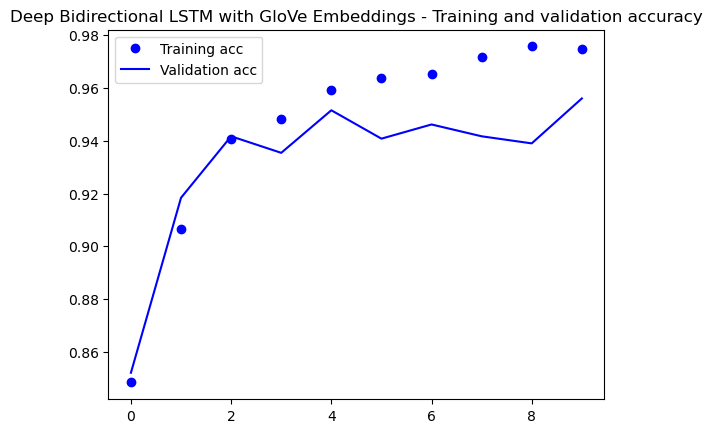

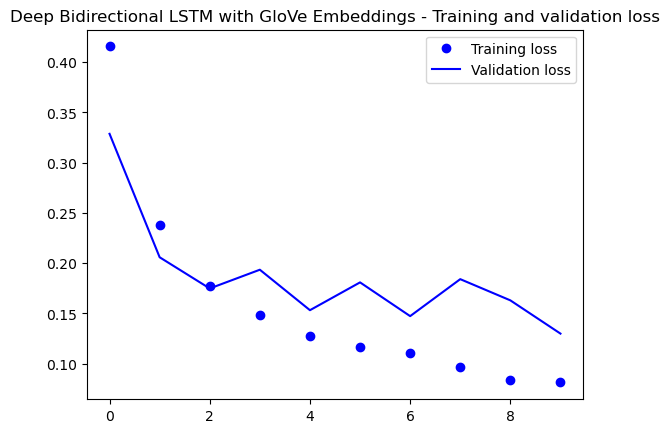

In [40]:
plot_training_history(deep_bidirectional_lstm_history, 'Deep Bidirectional LSTM with GloVe Embeddings')

In [41]:
# Evaluate the model
# deep_bidirectional_lstm_model and X_test, y_test are your test set and labels
evaluate_accuracy(deep_bidirectional_lstm_model, X_test, y_test)



35/35 [==============================] - 3s 60ms/step
Accuracy of simple_rnn_model: 0.9820627802690582


##### Bidirectional GRU with GloVe embeddings

In [42]:
# Bidirectional GRU with GloVe embeddings
bidirectional_gru_model = tf.keras.Sequential([
    Embedding(input_dim=max_features, output_dim=embedding_dim,
              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
              trainable=False),
    Bidirectional(GRU(32)),
    Dense(1, activation='sigmoid')
])

bidirectional_gru_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [43]:
    bidirectional_gru_history = bidirectional_gru_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
35/35 [==============================] - 7s 151ms/step - loss: 0.4794 - acc: 0.8129 - val_loss: 0.3985 - val_acc: 0.8520
Epoch 2/10
35/35 [==============================] - 5s 136ms/step - loss: 0.3567 - acc: 0.8694 - val_loss: 0.3677 - val_acc: 0.8520
Epoch 3/10
35/35 [==============================] - 5s 137ms/step - loss: 0.2865 - acc: 0.8811 - val_loss: 0.2393 - val_acc: 0.9157
Epoch 4/10
35/35 [==============================] - 5s 136ms/step - loss: 0.1834 - acc: 0.9381 - val_loss: 0.1902 - val_acc: 0.9336
Epoch 5/10
35/35 [==============================] - 5s 129ms/step - loss: 0.1569 - acc: 0.9459 - val_loss: 0.1717 - val_acc: 0.9408
Epoch 6/10
35/35 [==============================] - 5s 132ms/step - loss: 0.1408 - acc: 0.9536 - val_loss: 0.1653 - val_acc: 0.9453
Epoch 7/10
35/35 [==============================] - 5s 142ms/step - loss: 0.1252 - acc: 0.9614 - val_loss: 0.1710 - val_acc: 0.9390
Epoch 8/10
35/35 [==============================] - 5s 132ms/step - loss: 0.

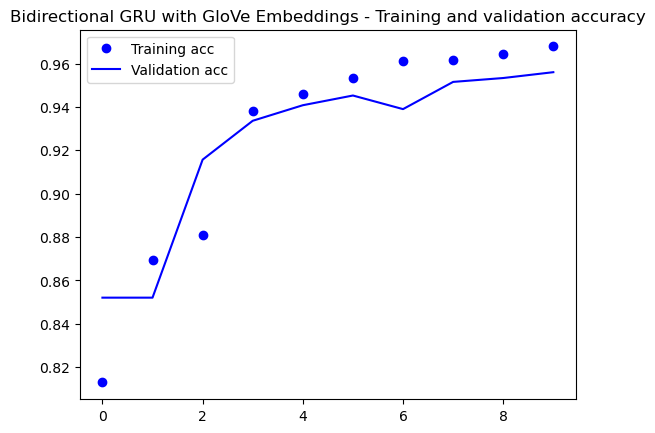

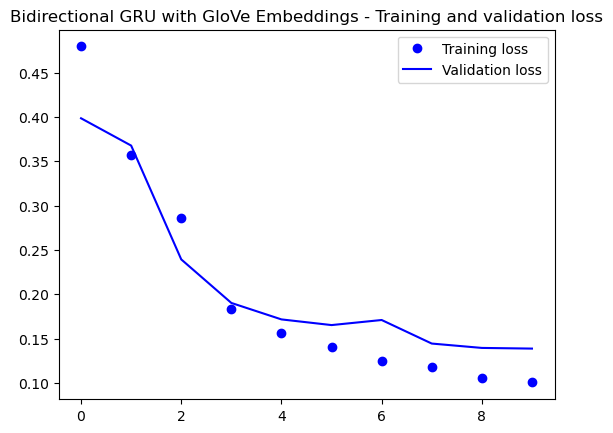

In [44]:
plot_training_history(bidirectional_gru_history, 'Bidirectional GRU with GloVe Embeddings')

In [45]:
# Evaluate the model
# bidirectional_gru_model and X_test, y_test are your test set and labels
evaluate_accuracy(bidirectional_gru_model, X_test, y_test)


35/35 [==============================] - 1s 21ms/step
Accuracy of simple_rnn_model: 0.9748878923766816


### Plotting the Attention Weights

175/175 [==============================] - 4s 21ms/step


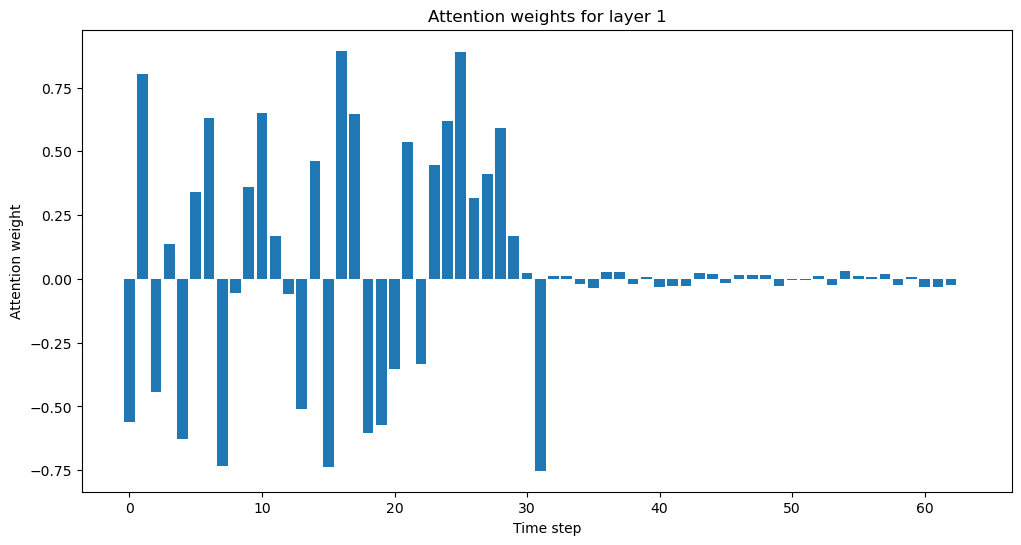

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_weights_for_all_layers(model, X_train, sample_idx=0):
    # Get the list of layers in the model
    layers = [layer for layer in model.layers if 'bidirectional' in layer.name]

    # Loop through each layer and plot attention weights
    for i, layer in enumerate(layers):
        # Define the attention model for this layer
        attention_model = tf.keras.Model(inputs=model.input,
                                         outputs=[layer.output, layer.output])

        # Get the attended output and attention weights
        attended_output, attention_weights = attention_model.predict(X_train)

        # Choose the attention weights for the given sample
        attention_weights_sample = attention_weights[sample_idx]

        # Plot the attention weights for the chosen sample
        plt.figure(figsize=(12, 6))
        plt.bar(range(len(attention_weights_sample)), attention_weights_sample)
        plt.xlabel('Time step')
        plt.ylabel('Attention weight')
        plt.title(f'Attention weights for layer {i+1}')
        plt.show()

# Usage example
# Assuming bidirectional_gru_model is your model and X_train is your training data
plot_attention_weights_for_all_layers(bidirectional_gru_model, X_train)


175/175 [==============================] - 2s 12ms/step


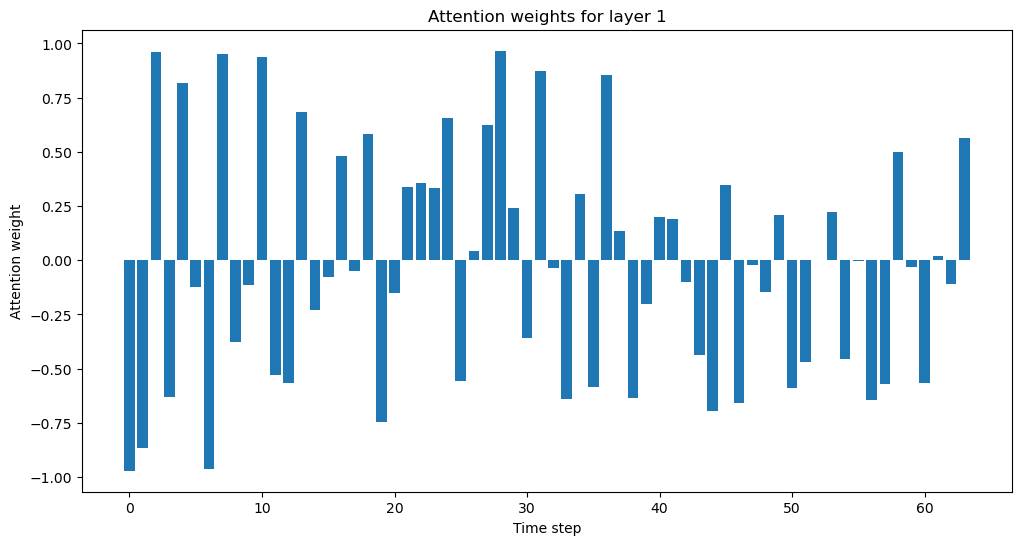

In [53]:

# Assuming bidirectional_gru_model is your model and X_train is your training data
plot_attention_weights_for_all_layers(bidirectional_rnn_model, X_train)
